<a href="https://colab.research.google.com/github/alejandro-robles7/fbai-mlops-assignments/blob/main/week_3/4B_Week_2_Offline_Fashion_MNIST_ML_Monitoring_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this assignment, we will train and test Convolutional Neural Network Models for multi-class image classification using the Pytorch framework. 

##**Our focus is NOT on training the best ML model, but monitoring ML model performance for test/production data.**

Please focus on your learnings from the **Weights and Biases** platform here.
The intention here is to monitor the classification outcome for batches of production data using the **Weights and Biases** platform.

Sources:
* [1] https://colab.research.google.com/drive/1X99lDIZt6fM1DCNWA65xnr7dW6qNvxbh?usp=sharing
* [2] Blog https://towardsdatascience.com/logging-with-weights-biases-da048e3cbc8b
* [3]https://colab.research.google.com/github/kjamithash/Pytorch_DeepLearning_Experiments/blob/master/FashionMNIST_ResNet_TransferLearning.ipynb#scrollTo=kSa1Bg3722Gz

## **Description of this Project**:  In this assignment, we are given the Fashion MNIST data set (https://www.kaggle.com/zalando-research/fashionmnist) with 60k training images and 10k test images, such that each image can be categorized as one of 10 output clothing categories. Our project demands the following:


---


##1. Train an off the shelf/simple image classifier and monitor the training process.
##2. Monitor the test sample batches for pre-production testing (ML Monitoring) to detect drifts in the production data.


---



# **Task 0**: Getting to know the data
Let us begin by loading the libraries and the data set.

In [1]:
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Since we will monitor the ML model training and production testing using Weights and Biases, create an account at https://wandb.ai and login. 
In the same browser launch this colab so authentication is automaticaly done.


In [2]:
%pip install wandb -q
import wandb
wandb.login()

wandb: Currently logged in as: alejandro-robles (use `wandb login --relogin` to force relogin)


True

In [3]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


## Step 2: Generate the Datasets and Dataloaders

len() function is used to calculate size of an object in python. For more information on len() see https://docs.python.org/3/library/functions.html#len

In [4]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dataloaders to feed the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=4)
prodloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)

# Print the number of train images, test images, train batches and test batches using len function discussed earlier. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


DataLoaders are used to load data in batches. 

# **Task 1**: Create a simple CNN model using Pytorch. You are NOT Required to learn the nitty gritty of a Pytorch CNN model, just use the code below as a sample codeblock for future assignments.

nn.Module is the bast class used for all neural network modules. Following is a CNN for FashionMNIST classification. 
(optional) For information on how nn.Module works see https://pytorch.org/docs/stable/generated/torch.nn.Module.html 
(optional) Fonr information on how layers in pytorch work see https://pytorch.org/docs/stable/nn.html

In [5]:
#Sample Pytorch Code#############################
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(12 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.reshape(-1, 12 * 4 * 4)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

## Next, let us declare some Helper Functions

find_acc function is used to calculate accuracy for the predictions and labels using the argmax function for 1st axis. train function is used to train the created model with the training data in the trainloader batch. validate function calculates the loss and accuracy for the test set. count_outcomes function calculates the number of outcomes in a given batch.  

In [6]:
def find_acc(pred, label):
    """pixelwise accuracy"""
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

def train(network, epoch, criterion, optimizer, trainloader):
    loss_train = 0
    acc_train = 0
    network.train()
    
    for step in range(len(trainloader)):

        images , labels = next(iter(trainloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        acc_train += acc_train_step  
            
        loss_train /= len(trainloader)
        acc_train /= len(testloader)

        return loss_train, acc_train  
        
def validate(network, epoch, criterion, testloader): 
    loss_valid = 0
    acc_valid = 0       
    network.eval()  

    for step in range(len(testloader)):

        images , labels = next(iter(testloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
        acc_valid += acc_valid_step

        loss_valid /= len(trainloader)
        acc_valid /= len(testloader)

        return loss_valid, acc_valid



def count_outcomes(arr):
  res=np.zeros(10)
  for x in range(10):
    for i in range(len(arr)):
        if x == arr[i]:
            res[x]=res[x]+1
  return res

#**Task 2**: Train the simple CNN Network and watch the model logs at the **Weights and Biases** portal.

In [7]:
# %timeit
start_time = time.time()

# Initialize WandB 

# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is the first run', 
           tags=['Fashion MNIST', 'Test Run'])

# WandB Configurations (optional)        
wandb.config.lr = 0.01    

network = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), wandb.config.lr)

# Log the network weight histograms (optional)
wandb.watch(network)

num_epochs = 100
start_time = time.time()
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(network, epoch, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(network, epoch, criterion, testloader)
    
    #Print the epoch number, training loss, training accuracy, validation loss and validation accuracy for each epoch
    print(f'Epoch: {epoch}  Train Loss: {loss_train}  Train Acc: {acc_train}  Valid Loss: {loss_valid}  Valid Acc: {acc_valid}')
    # Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid})

# Print the time taken for training the data. It can be calculated using the difference between current time and start time. 
# Current time can be retrieved using time.time()

print("--- %s seconds ---" % (time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1  Train Loss: 0.03841646909713745  Train Acc: 0.1120000034570694  Valid Loss: 0.03822486797968547  Valid Acc: 0.17000000178813934
Epoch: 2  Train Loss: 0.038218589623769124  Train Acc: 0.2110000103712082  Valid Loss: 0.03785462379455566  Valid Acc: 0.08999999612569809
Epoch: 3  Train Loss: 0.03776565392812093  Train Acc: 0.11100000888109207  Valid Loss: 0.03643521070480347  Valid Acc: 0.11999999731779099
Epoch: 4  Train Loss: 0.036853639284769694  Train Acc: 0.09700000286102295  Valid Loss: 0.03489631017049154  Valid Acc: 0.1899999976158142
Epoch: 5  Train Loss: 0.03523516654968262  Train Acc: 0.21000000834465027  Valid Loss: 0.030541475613911948  Valid Acc: 0.4099999964237213
Epoch: 6  Train Loss: 0.03134496410687764  Train Acc: 0.3240000009536743  Valid Loss: 0.02791831692059835  Valid Acc: 0.3999999761581421
Epoch: 7  Train Loss: 0.0280424435933431  Train Acc: 0.3680000305175781  Valid Loss: 0.025953813393910726  Valid Acc: 0.3700000047683716
Epoch: 8  Train Loss: 0.02559602

# Attach snapshot of your **Weights and Biases** plot here! Add a few lines of your findings so far...
## Next, predict on Test Dataset..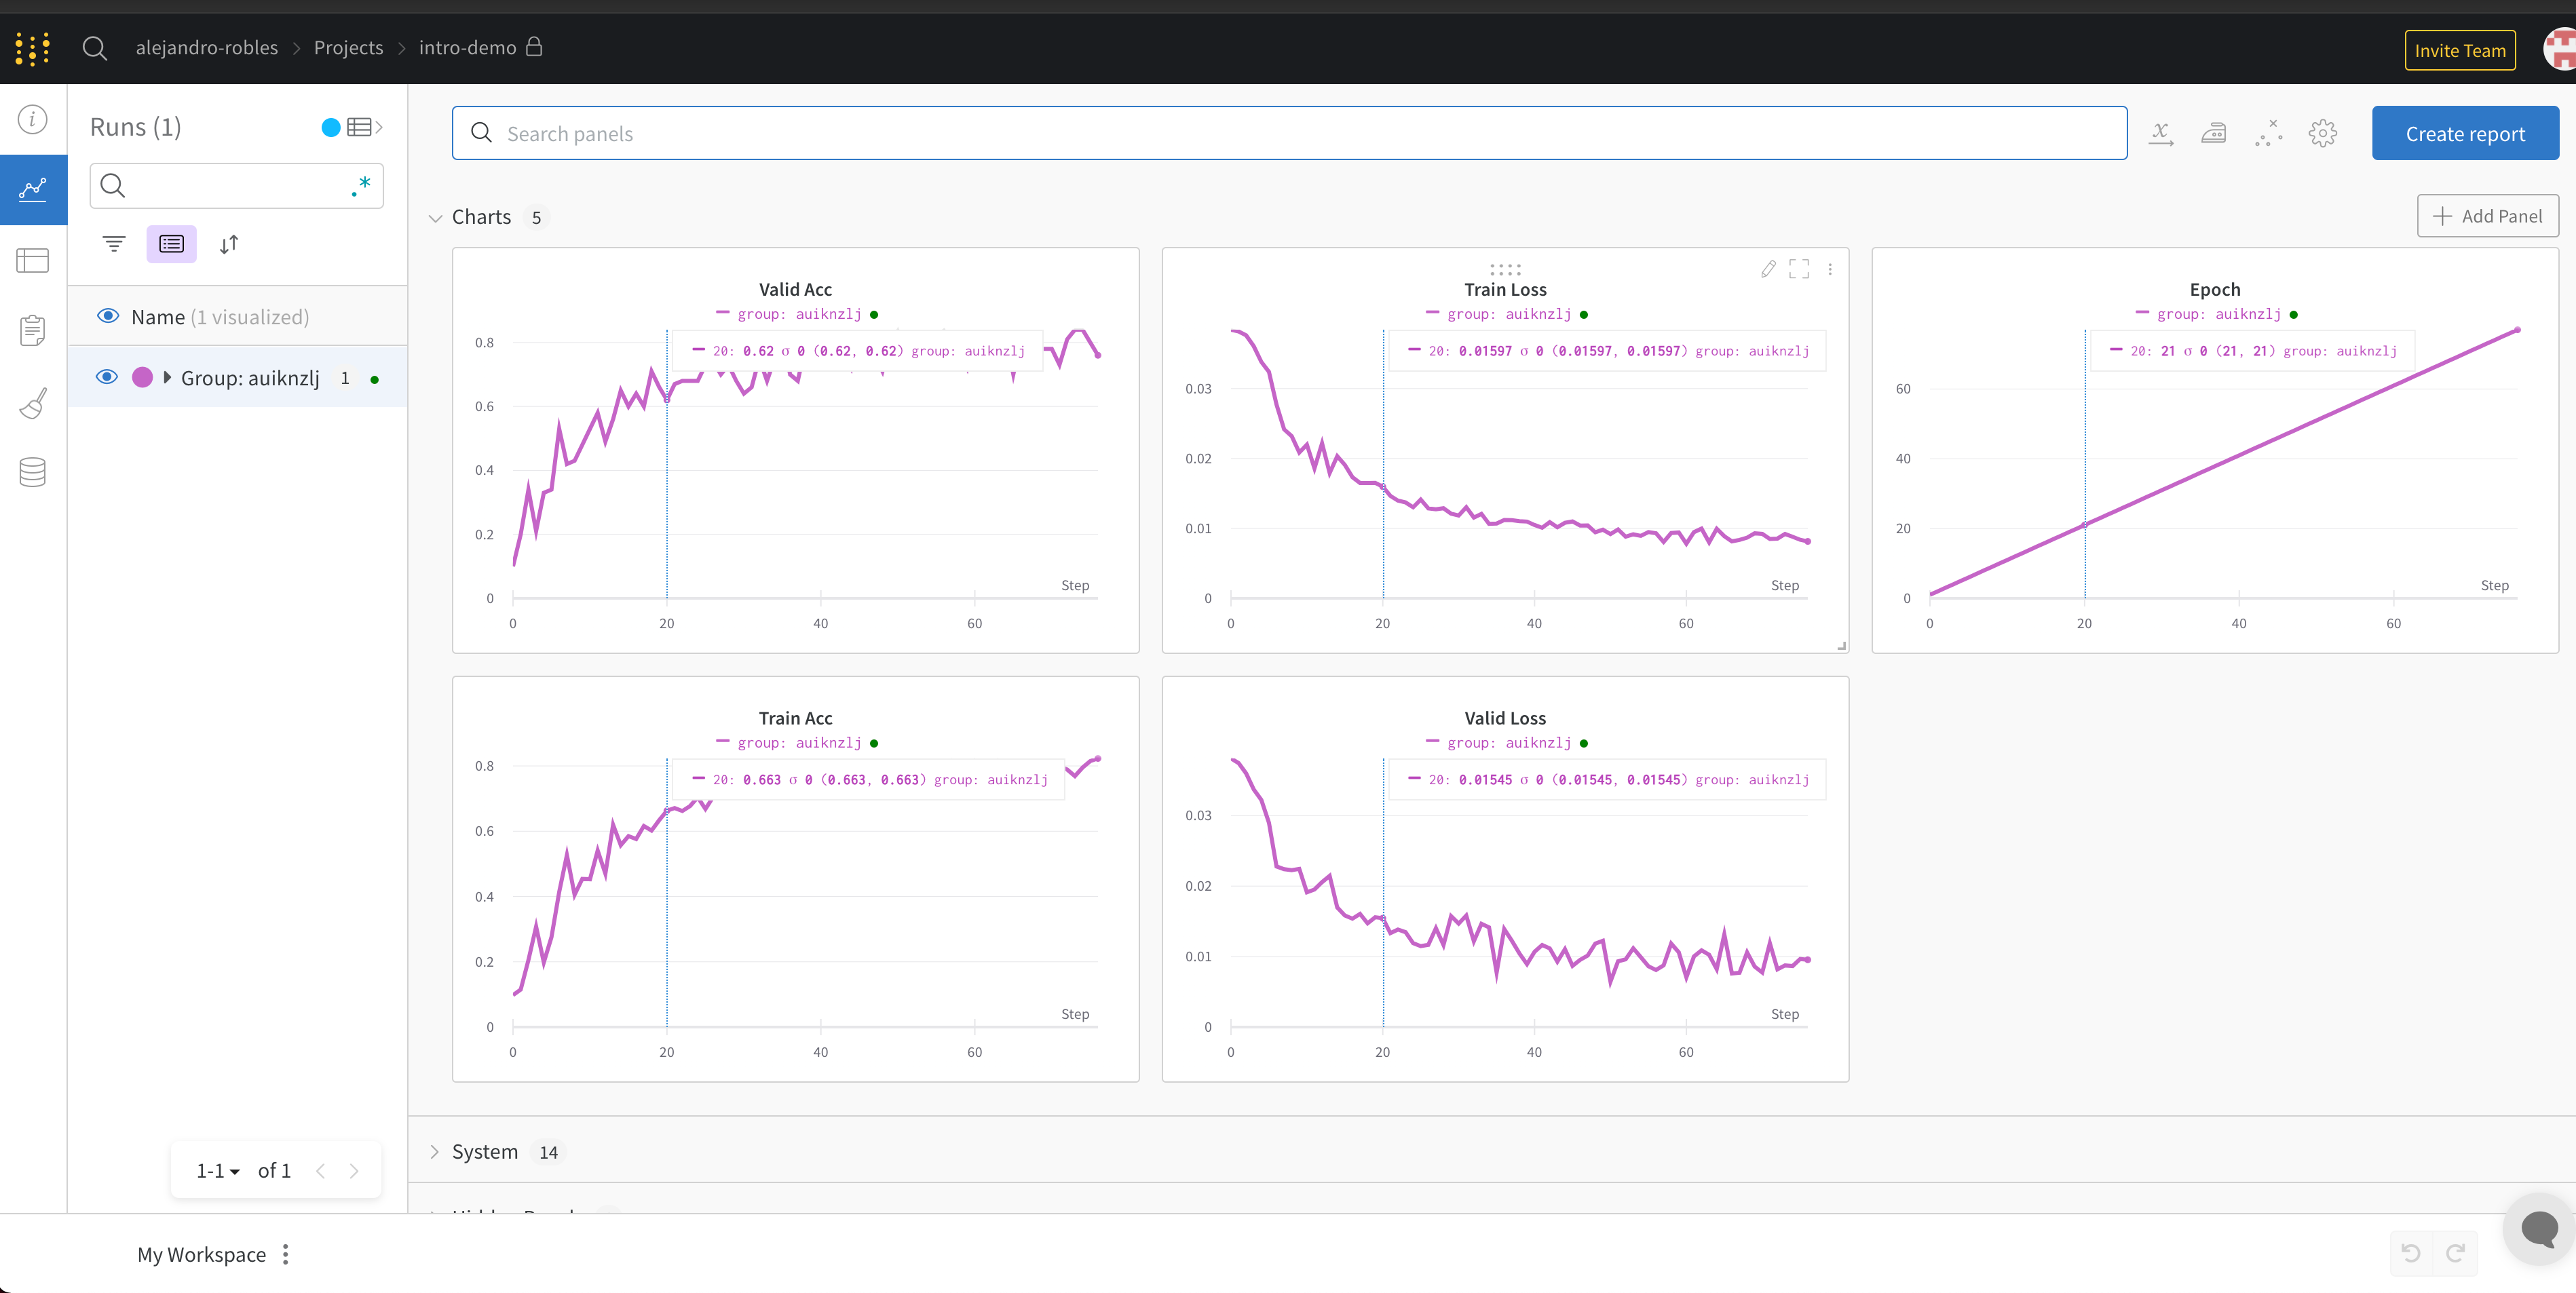

# Now you know how to train and test a CNN model for image classification!

In [8]:
def test_model(model):

    start_time = time.time()

    num_correct = 0
    accuracy = 0

    with torch.no_grad():

        for batch in testloader:

            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            total_images = len(testset)

            pred = model(images)

            num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()

            accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()

            num_correct += num_correct_batch
            accuracy += accuracy_batch

        accuracy /= len(testloader)

    # Print the numer of test images, correct predictions and accuracy for the test dataset.
    print('Number of test images:', len(labels))
    print('Number of correct predictions:',num_correct)
    print('Accuracy of test images:',accuracy)

    # Print the time taken for predicting the data. It can be calculated using the difference between current time and start time. 
    # Current time can be retrieved using time.time()
    print("--- %s seconds ---" % (time.time() - start_time))
    
# test the trained network    
test_model(network)    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number of test images: 100
Number of correct predictions: 8066
Accuracy of test images: 0.8065999788045883
--- 1.50471830368042 seconds ---


# **Task 3**: Transfer Learning. To leverage pre-trained models, we will now declare a new Network that is pre-trained (Resnet50).
## Your task here is to train this new network and monitor the training process on **Weights and Biases** as in Task 2.


In [9]:
# Start here###########################
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import matplotlib.pyplot as plt
import numpy as np

In [10]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(pretrained=True)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)




## Next, initialize **Weights and Biases** as you did in Task 2 to train and test the fine-tuned version of Resnet50.

We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

In [11]:

# Initialize WandB 
# Set an experiment name to group training and evaluation
start_time = time.time()
experiment_name = wandb.util.generate_id()

wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is a second run', 
           tags=['Fashion MNIST', 'Test Run'])

network = MnistResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=3e-4)

# Log the network weight histograms (optional)
wandb.watch(network)

num_epochs = 100
start_time = time.time()
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(network, epoch, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(network, epoch, criterion, testloader)
    
    #Print the epoch number, training loss, training accuracy, validation loss and validation accuracy for each epoch
    print(f'Epoch: {epoch}  Train Loss: {loss_train}  Train Acc: {acc_train}  Valid Loss: {loss_valid}  Valid Acc: {acc_valid}')

    # Log the loss and accuracy values at the end of each epoch
    # ADD THE LOGING CODE HERE BY REFERING THE LINK PROVIDED
    wandb.log({
    "Epoch": epoch,
    "Train Loss": loss_train,
    "Train Acc": acc_train,
    "Valid Loss": loss_valid,
    "Valid Acc": acc_valid})

# Print the time taken for training the data. It can be calculated using the difference between current time and start time. 
# Current time can be retrieved using time.time()
print("--- %s seconds ---" % (time.time() - start_time))


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Acc,▁▁▃▄▄▅▅▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
Train Loss,██▆▅▅▄▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Acc,▁▁▄▄▅▅▄▅▅▆▆▆▇▆▇▇█▇▆▇▇▇▇▇█▆█▇▇▇▇▇█▇▇▇████
Valid Loss,██▆▅▄▃▄▃▃▃▃▃▂▂▂▂▁▂▃▂▂▁▁▁▁▂▁▁▂▂▂▂▁▂▁▂▁▁▁▁
Epoch,100
Train Acc,0.809
Train Loss,0.008
Valid Acc,0.8
Valid Loss,0.00844


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1  Train Loss: 0.03934348424275716  Train Acc: 0.1080000028014183  Valid Loss: 0.03801188468933105  Valid Acc: 0.10999999940395355
Epoch: 2  Train Loss: 0.03038261334101359  Train Acc: 0.4440000355243683  Valid Loss: 0.039856080214182535  Valid Acc: 0.07999999821186066
Epoch: 3  Train Loss: 0.02277945280075073  Train Acc: 0.6190000176429749  Valid Loss: 0.04576096932093302  Valid Acc: 0.08999999612569809
Epoch: 4  Train Loss: 0.017945017417271933  Train Acc: 0.687000036239624  Valid Loss: 0.05891835689544678  Valid Acc: 0.07000000029802322
Epoch: 5  Train Loss: 0.014272480209668478  Train Acc: 0.7130000591278076  Valid Loss: 0.06381459633509318  Valid Acc: 0.07000000029802322
Epoch: 6  Train Loss: 0.012545739610989889  Train Acc: 0.7450000643730164  Valid Loss: 0.052265008290608726  Valid Acc: 0.1599999964237213
Epoch: 7  Train Loss: 0.012164143721262614  Train Acc: 0.7480000257492065  Valid Loss: 0.05136113961537679  Valid Acc: 0.10999999940395355
Epoch: 8  Train Loss: 0.010726

# Now, let us visualize some of the predictions


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


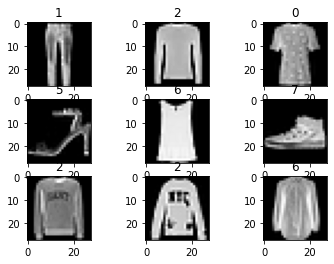

In [12]:
for batch in testloader:
    images, labels = batch
    for i in range(0, 9):
            plt.subplot(330+1 + i)
            plt.imshow(np.reshape(images[i],(28,28)), cmap=plt.get_cmap('gray'))
            plt.title(np.array(labels[i]))

    plt.show()
    break

# **Task 4**: Now that we have trained two CNN models, we need to monitor their progress on production data.

## Notice that at production time, you dont have access to groundtruth (i.e. actual labels). Let us answer these questions first! Write the answers to these questions below.
## Q1: **What could be some metrics that you monitor at production time?** Think about data and concept drift that neeeds to be monitored.
## Q2: If you had data flow **in batches**, as opposed to individual samples, **what would your metrics to be monitored be**?

--------------------------------------------------------------------------------

## **HINTS**: 
### 1. Think of data in batches of 10 (since 10 classes equally likely for data distribution here). Now, if the distribution of data in batches of 10 changes from uniform to something else that that would mean **DATA DRIFT**. So you could count the number of predicted samples per class and use that as a metric to identify Data Drift.
###2. Model output is always probabilistic. So if the range of probabilities (max prob and mean prob) shifts across batches, that can mean a certain degree of concept drift.


#Q1 

*   Chi square test to test for uniform distribution
*   Frequency of the mode
* Kolmogorov Smirnov test 
* |p(x|y=1) - p(x|y=2)| = diff, does diff change over time?
* p(x)

#Q2

* Log the quantiles of the probabilities and check for drift
* If the probabilites are close to 50% 


## Now that you have an idea of some prodction metrics you need to mobitor, initialize a new **Weights and Biases** Run and monitor the metrics for some epochs.

We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

# Please remember to start a NEW RUN to log your data or else you will NOT be able to infer from the plots.


In [13]:
experiment_name = wandb.util.generate_id()
wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is Test Run', 
           tags=['Fashion MNIST', 'Production'])



num_epochs = 30

for epoch in range(1, num_epochs+1):
  #Next let us declare the metrics to monitor at production time
  # Initialize all the matrics that we are goint to monitor here. 
  # Initialize accuracy, number of correct predictions, start time, minimum batch output, maximum batch output and number of batches here. 
  # NOTE: Current time can be calculated using time.time() function. Here, the start_time would be current time.
  ##### Write code to monitor the metrics you decided at run time###########

    # Re-setting parameters
    num_batches=0
    num_correct_batch = 0
    accuracy_batch = 0
    num_correct = 0
    accuracy = 0
    max_val=0
    min_val=0
    max_batch_op = list()
    min_batch_op = list()

    for batch in prodloader: # Consider a batch of 10 images at a time
      start_time = time.time()
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      # We are trying to calculate the total number of images for the test. 
      # ADD YOUR CODE TO CALCULATE TOTAL NUMBER OF IMAGES IN THE TEST SET
      total_count_test_images = len(labels)

      # We are going to get the predictions for the images from the network here.
      # ADD YOUR CODE TO PASS IMAGES PER BATCH TO THE NETWORK HERE
      pred = network(images)
      pred_batch=sorted(pred.argmax(dim=1).cpu().numpy())

      # We are going to calculate the number of outcomes for each prediction batch using count_outcomes function declared earlier.
      #ADD YOUR CODE HERE TO COUNT THE NUMBER OF OUTCOMES USING count_outcomes FOR prediction batch HERE
      num_batch = count_outcomes(pred_batch)
      num_batches=num_batches+num_batch
      num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()
      accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()
      num_correct +=num_correct_batch
      accuracy += accuracy_batch
      max_val=np.max(pred.max(dim=1).values.cpu().detach().numpy())
      min_val=np.min(pred.min(dim=1).values.cpu().detach().numpy())
      max_batch_op.append(max_val)
      min_batch_op.append(min_val)
  
  # The batch time for each batch would be the difference between current time and start time.
  # ADD YOUR CODE TO CALCULATE batch_time HERE
      batch_time = time.time() - start_time

      print(num_correct, accuracy/len(prodloader), batch_time, num_batches, max(max_batch_op),min(min_batch_op))

  # Log the metrics defined earlier 
    # ADD THE LOGING CODE FOR METRICS HERE BY REFERING THE LINK PROVIDED
    # THE VALUES THAT WE ARE LOGING ARE batch time, number of current predictions, batch accuracy, maximum batch output, minimum batch output, number of predictions for each batch.
  
    wandb.log({
        "Batch Time": batch_time,
        "Number of Current Predictions": num_batches,
        "Batch Accuracy": accuracy_batch,
        "Maximum Batch Output": max(max_batch_op),
        "Minimum Batch Output": min(min_batch_op),
        "Number of Predictions per batch": num_batch
        }) 


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Acc,▁▅▆▇▇▇▇▇▇▇▇█▇███▇███████████████████████
Train Loss,█▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Acc,▁▁▂▁▂▁▃▂▂▄▃▄▄▅▅▆▆▆▆▇█▇▇▇▇█▇▇███▇███▇███▇
Valid Loss,▆▇████▆▆▆▄▄▄▄▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Train Acc,0.898
Train Loss,0.00412
Valid Acc,0.84
Valid Loss,0.00638


Streaming output truncated to the last 5000 lines.
7 0.000699999988079071 0.025042295455932617 [2. 1. 0. 3. 0. 1. 0. 2. 0. 1.] 11.249739 -4.2546988
16 0.0016000000238418578 0.017814159393310547 [4. 2. 1. 5. 0. 1. 1. 3. 1. 2.] 11.249739 -5.052578
26 0.002600000023841858 0.019635438919067383 [4. 3. 2. 7. 0. 2. 2. 4. 3. 3.] 13.579479 -5.6280394
36 0.003600000023841858 0.0182647705078125 [5. 6. 3. 8. 1. 3. 2. 4. 3. 5.] 13.579479 -5.6280394
44 0.004400000035762787 0.017672061920166016 [7. 6. 5. 9. 1. 4. 2. 5. 3. 8.] 13.579479 -5.6280394
52 0.005200000047683716 0.017871379852294922 [9. 8. 6. 9. 2. 6. 2. 6. 4. 8.] 13.579479 -5.6280394
60 0.006000000059604645 0.018250226974487305 [10. 11.  7.  9.  3.  6.  5.  6.  4.  9.] 13.579479 -5.6280394
69 0.006900000095367432 0.0189821720123291 [11. 14.  9.  9.  4.  6.  6.  7.  4. 10.] 13.579479 -5.6280394
79 0.007900000095367432 0.03199338912963867 [11. 15. 12.  9.  4.  8.  6.  7.  4. 14.] 13.579479 -5.6280394
88 0.008800000131130218 0.01837563514709472

# **Task 5**: Let us modify the production data, using augmentation techniques and observe the model metrics with the augmented data. 
This will give an idea about how "drft" occurs in ML model. The goal is to identify is the drift between input and output (concept drift) or because of the data (data drift).

In [14]:
transformations = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomCrop((28,28), fill=0, padding_mode='constant'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=1),
    transforms.RandomRotation(180)
])


## Let us visualize the image transformations. Run the cell underneath a few times and observe the transformations.

Matplotlib is used to display the images. We are going to use imshow to display the images after reshaping them in (28,28) size. And then we will add title to images to have more information about them. For information on imshow() see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html. 
For more information on title() see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html 
To reshape the image, we will use reshape function from numpy. 
For more information on reshape, see https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

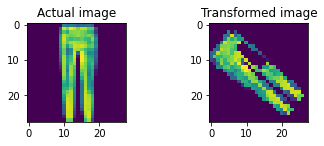

In [17]:
#Run 3-5 times

# We are going to visualize various images with their transformed images.  

for batch in prodloader: # Consider a batch of 10 images at a time
    images, labels = batch
    #Let us get an idea of the 
    plt.subplot(220+1)
    # reshape the actual image to (28,28) dimension using the link provided.
    # ADD YOUR CODE TO RESHAPE THE ACTUAL IMAGE HERE
    sample_image_resize = images[0].reshape((28, 28))
    # Plot the actual image from the batch using imshow using the link provided
    # ADD YOUR ACTUAL IMAGE PLOT CODE HERE
    plt.title("Actual image")
    plt.imshow(sample_image_resize)

    # Transform the images by passing them to transformations function above
    # ADD YOUR CODE TO PASS THE IMAGE TO THE transformations function AND GET THE TRANSFORMED IMAGE HERE
    plt.subplot(220+1+1)

    # reshape the reformed image to (28,28) dimension using the link provided.
    # ADD YOUR CODE TO RESHAPE THE TRANSFORMED IMAGE HERE
    transformed_image = transformations(images)    
    # Plot the transformed image from the batch using imshow using the link provided
    # ADD YOUR TRANSFORMED IMAGE PLOT CODE HERE
    plt.title("Transformed image")
    plt.imshow(transformed_image[0][0])
    break


We are going to log the output in Weights and Biases. For more information on how to log in Weights and Biases see https://docs.wandb.ai/ref/python/log

#Remember to start a new run here!

In [16]:
experiment_name = wandb.util.generate_id()
wandb.init(project="intro-demo",
           group=experiment_name,
           notes='This is Test Run', 
           tags=['Fashion MNIST', 'Production'])

num_epochs = 30

for epoch in range(1, num_epochs+1):
  #Next let us declare the metrics to monitor at production time
  # Initialize all the matrics that we are goint to monitor here. 
  # Initialize accuracy, number of correct predictions, start time, minimum batch output, maximum batch output and number of batches here. 
  # NOTE: Current time can be calculated using time.time() function. Here, the start_time would be current time.
  print(epoch)
  start_time = time.time()
  num_batches=0
  num_correct_batch = 0
  accuracy_batch = 0
  num_correct = 0
  accuracy = 0
  max_val=0
  min_val=0
  max_batch_op = list()
  min_batch_op = list()


  ## Monitor the same metrics in Task 4 with augenmented test data
  for batch in prodloader: # Consider a batch of 10 images at a time
    images, labels = batch
    images=transformations(images)    
    images = images.to(device)
    labels = labels.to(device)
    # We are trying to calculate the total number of images for the test. 
    # ADD YOUR CODE TO CALCULATE TOTAL NUMBER OF IMAGES IN THE TEST SET
    total_count_test_images = len(labels)
    # We are going to get the predictions for the images from the network here.
    # ADD YOUR CODE TO PASS IMAGES PER BATCH TO THE NETWORK HERE
    pred = network(images)
    pred_batch=sorted(pred.argmax(dim=1).cpu().numpy())

    # We are going to calculate the number of outcomes for each prediction batch using count_outcomes function declared earlier.
    #ADD YOUR CODE HERE TO COUNT THE NUMBER OF OUTCOMES USING count_outcomes FOR prediction batch HERE

    num_batches=num_batches+num_batch
    num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()
    accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()
    num_correct +=num_correct_batch
    accuracy += accuracy_batch
    max_val=np.max(pred.max(dim=1).values.cpu().detach().numpy())
    min_val=np.min(pred.min(dim=1).values.cpu().detach().numpy())
    max_batch_op.append(max_val)
    min_batch_op.append(min_val)
 
    batch_time=time.time() - start_time
    print(num_correct, accuracy/len(prodloader), batch_time, num_batches, max(max_batch_op),min(min_batch_op))


  
  # Log the metrics defined earlier 
    # ADD THE LOGING CODE FOR METRICS HERE BY REFERING THE LINK PROVIDED
    # THE VALUES THAT WE ARE LOGING ARE batch time, number of current predictions, batch accuracy, maximum batch output, minimum batch output, number of predictions for each batch.
    wandb.log({
      "Batch Time": batch_time,
      "Number of Current Predictions": num_batches,
      "Batch Accuracy": accuracy_batch,
      "Maximum Batch Output": max(max_batch_op),
      "Minimum Batch Output": min(min_batch_op),
      "Number of Predictions per batch": num_batch
      }) 

Batch Accuracy,▇█▇▇▇▇▄▇█▄▇▇▄█▇▅▇▇▅█▄▇▄▇█▇▇█▁▇
Batch Time,▂▆▁█▂▂▂▆▁▂▁▁▂▄▃▁▁▂▁▄▂▂▁▁▇▂▂▃▂▂
Maximum Batch Output,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Minimum Batch Output,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batch Accuracy,0.9
Batch Time,0.01901
Maximum Batch Output,18.71203
Minimum Batch Output,-7.37766


Streaming output truncated to the last 5000 lines.
4 0.00040000000596046445 0.15946269035339355 [ 0.  5.  5.  5. 10.  0.  0. 15.  5.  5.] 8.829794 -4.435757
6 0.0006000000089406968 0.18963384628295898 [ 0.  6.  6.  6. 12.  0.  0. 18.  6.  6.] 8.829794 -4.435757
11 0.0011000000089406968 0.2183856964111328 [ 0.  7.  7.  7. 14.  0.  0. 21.  7.  7.] 8.829794 -4.77388
11 0.0011000000089406968 0.2474973201751709 [ 0.  8.  8.  8. 16.  0.  0. 24.  8.  8.] 8.829794 -4.77388
15 0.0015000000149011613 0.27921009063720703 [ 0.  9.  9.  9. 18.  0.  0. 27.  9.  9.] 8.829794 -4.77388
18 0.00180000002682209 0.31162548065185547 [ 0. 10. 10. 10. 20.  0.  0. 30. 10. 10.] 12.371141 -4.77388
20 0.0020000000298023225 0.3435089588165283 [ 0. 11. 11. 11. 22.  0.  0. 33. 11. 11.] 12.371141 -4.77388
23 0.0023000000417232516 0.3826003074645996 [ 0. 12. 12. 12. 24.  0.  0. 36. 12. 12.] 12.371141 -5.032915
24 0.0024000000432133676 0.4129786491394043 [ 0. 13. 13. 13. 26.  0.  0. 39. 13. 13.] 12.371141 -5.032915
26 0

![picture](https://drive.google.com/uc?id=1EPv6AKkJVCUdRpyJGFu9sGicdPlznQDG)

# Your test plots from Task 4 and Task 5 combined should look like this. Notice that for non-transformed data (in Task 4) the predictions were straight lines. As soon as transformed data is fed into the system, purturbations start, which shows data drift!

# Notice how the monitoring curves have changed, thus showing that there is a drift and two follow ups should happen:
* ML model must be retrained with the transformed images
* If an ML model is trained with upright images only, checks must be done at run-time to prevent transformed images to be applied as test data.

## Summarize all your findings below and think of how you will devise production-time metrics.



*   Visualizing data drift is great but how do we automate retraining?
*   Simulating data drift is a nice trick, can this be part of unit testing? 
*   Can we set alerts if data drift is detected
*   How does this integrate with AWS/GCP?
*   Can we make things configurable with a yaml file?
